In [10]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import shutil


In [11]:
##############################################################################
# 1) SETUP: CREATE A FOLDER TO STORE FIGURES & CSV
##############################################################################

timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_folder = f"{timestamp_str}_plots"
os.makedirs(save_folder, exist_ok=True)


In [12]:
##############################################################################
# 2) LOAD & PREP DATA
##############################################################################

# Path to your DLC-exported CSV
file_path = '/Users/jamesxu/Desktop/Crab Lab/surface swimmer/dlc_analysis/40cm_trial_3/40cm_run5DLC_resnet50_40cm_newOct1shuffle1_100000_filtered.csv'

# Copy the *original* CSV into the output folder, too
shutil.copy2(file_path, os.path.join(save_folder, os.path.basename(file_path)))

# Real-world frame size (in meters)
real_width_m = 1.2
real_height_m = 0.55

# Video frame size (in pixels), ensuring same orientation
frame_width_pixels = 1920
frame_height_pixels = 884

# Video frame rate
video_fps = 30

# Load the CSV: the DLC multi-level headers are typically on rows 1 & 2 (0-based)
data = pd.read_csv(file_path, header=[1, 2])

# Extract 'x' and 'y' coordinates into separate DataFrames
x_coords = data.xs('x', level=1, axis=1)
y_coords = data.xs('y', level=1, axis=1)

# Drop rows with NaN (optional)
x_coords = x_coords.dropna()
y_coords = y_coords.dropna()


In [13]:
##############################################################################
# 2.1) (OPTIONAL) CROP THE DATA
##############################################################################
# If the beginning or ending frames are noisy, you can drop them here.
# Adjust 'n_drop_front' and 'n_drop_end' as needed. 

n_drop_front = 100  # e.g., drop first 100 frames
n_drop_end = 100      # e.g., drop last 0 frames (none)

# Handle the slicing
if n_drop_end > 0:
    x_coords = x_coords.iloc[n_drop_front:-n_drop_end]
    y_coords = y_coords.iloc[n_drop_front:-n_drop_end]
else:
    x_coords = x_coords.iloc[n_drop_front:]
    y_coords = y_coords.iloc[n_drop_front:]

def pixels_to_meters(x_pixels, y_pixels,
                     real_width_m=real_width_m, real_height_m=real_height_m,
                     frame_width_pixels=frame_width_pixels, frame_height_pixels=frame_height_pixels):
    """
    Convert pixel coordinates to real-world meters (assuming uniform scaling).
    """
    x_meters = x_pixels * (real_width_m / frame_width_pixels)
    y_meters = y_pixels * (real_height_m / frame_height_pixels)
    return x_meters, y_meters

# Convert from pixels -> meters
x_m, y_m = pixels_to_meters(x_coords, y_coords)

# Overwrite original x_coords, y_coords with meter-based coords
x_coords = x_m
y_coords = y_m

In [14]:
##############################################################################
# 3) SPLINE FUNCTIONS (SIGNED(+-) CURVATURE)
##############################################################################

def compute_curvature_spline(x_points, y_points, num_points=100, smoothing=0.01):
    """
    Param-based spline with SIGNED curvature (units: 1/m if x,y in meters).
    k = (dx*ddy - dy*ddx) / ((dx^2 + dy^2)^(3/2))
    """
    tck, _ = splprep([x_points, y_points], s=smoothing, k=3)
    u_eval = np.linspace(0, 1, num_points)

    # Evaluate the spline and its derivatives
    x_spl, y_spl = splev(u_eval, tck, der=0)
    dx, dy       = splev(u_eval, tck, der=1)
    ddx, ddy     = splev(u_eval, tck, der=2)

    # Signed curvature
    signed_numerator = dx * ddy - dy * ddx
    denominator = (dx**2 + dy**2)**1.5

    curvature = np.zeros_like(signed_numerator)
    valid = denominator > 0
    curvature[valid] = signed_numerator[valid] / denominator[valid]

    return curvature, x_spl, y_spl

def compute_spline_curvatures_all_frames(x_df, y_df, num_points=100, smoothing=0.01):
    """
    Param-based approach for ALL frames (SIGNED curvature).
    Returns curvature in 1/m if x,y are in meters.
    """
    n_frames = x_df.shape[0]
    all_curv = np.zeros((n_frames, num_points))
    all_x_spl = []
    all_y_spl = []

    for i in range(n_frames):
        x_points = x_df.iloc[i].values
        y_points = y_df.iloc[i].values

        curv_i, xspl_i, yspl_i = compute_curvature_spline(
            x_points, y_points, num_points=num_points, smoothing=smoothing
        )
        all_curv[i, :] = curv_i
        all_x_spl.append(xspl_i)
        all_y_spl.append(yspl_i)

    return all_curv, all_x_spl, all_y_spl


def compute_marker_curvatures_spline(x_points, y_points, smoothing=0.01):
    """
    Marker-based spline with SIGNED curvature (units: 1/m if x,y in meters).
    """
    tck, u = splprep([x_points, y_points], s=smoothing, k=3)

    M = len(x_points)
    curvatures = np.zeros(M)
    for i in range(M):
        dx, dy   = splev(u[i], tck, der=1)
        ddx, ddy = splev(u[i], tck, der=2)

        signed_numerator = dx * ddy - dy * ddx
        denom = (dx**2 + dy**2)**1.5
        if denom > 0:
            curvatures[i] = signed_numerator / denom
        else:
            curvatures[i] = 0.0

    return curvatures

def compute_all_marker_curvatures_spline(x_df, y_df, smoothing=0.01):
    """
    Marker-based approach for ALL frames (SIGNED curvature), in 1/m if x,y in meters.
    """
    n_frames, n_markers = x_df.shape
    all_curv = np.zeros((n_frames, n_markers))

    for i in range(n_frames):
        x_points = x_df.iloc[i].values
        y_points = y_df.iloc[i].values
        curv_i = compute_marker_curvatures_spline(x_points, y_points, smoothing=smoothing)
        all_curv[i, :] = curv_i

    return all_curv

In [15]:
##############################################################################
# 4) COMPUTE CURVATURE (Marker-based & Param-based)
##############################################################################

smoothing_factor = 0.01
num_spline_points = 100

# (A) Marker-based (signed curvature)
curvatures_marker = compute_all_marker_curvatures_spline(
    x_coords, y_coords, smoothing=smoothing_factor
)

# (B) Param-based (signed curvature)
curvatures_param, x_splines, y_splines = compute_spline_curvatures_all_frames(
    x_coords, y_coords,
    num_points=num_spline_points,
    smoothing=smoothing_factor
)

N_frames = curvatures_marker.shape[0]
M_markers = curvatures_marker.shape[1]
time_s = np.arange(N_frames) / video_fps
markers_all = x_coords.columns  # or y_coords.columns
last_frame = N_frames - 1

In [16]:
##############################################################################
# 5) THRESHOLDING & REMOVE OUTLIERS FOR PLOTS(e.g. |curvature| > 100 => NaN)
##############################################################################
mask_marker = np.abs(curvatures_marker) > 100
curvatures_marker[mask_marker] = np.nan

mask_param = np.abs(curvatures_param) > 100
curvatures_param[mask_param] = np.nan

In [17]:
##############################################################################
# 6) SAVE CURVATURE DATA TO CSV
##############################################################################
df_marker = pd.DataFrame(curvatures_marker, columns=markers_all)
df_marker.insert(0, "Time_s", time_s)
marker_csv_path = os.path.join(save_folder, "curvature_marker.csv")
df_marker.to_csv(marker_csv_path, index=False)

df_param = pd.DataFrame(curvatures_param, columns=[f"param_{i}" for i in range(num_spline_points)])
df_param.insert(0, "Time_s", time_s)
param_csv_path = os.path.join(save_folder, "curvature_param.csv")
df_param.to_csv(param_csv_path, index=False)

print(f"Saved CSV files:\n  {marker_csv_path}\n  {param_csv_path}")

Saved CSV files:
  20250103_105958_plots/curvature_marker.csv
  20250103_105958_plots/curvature_param.csv


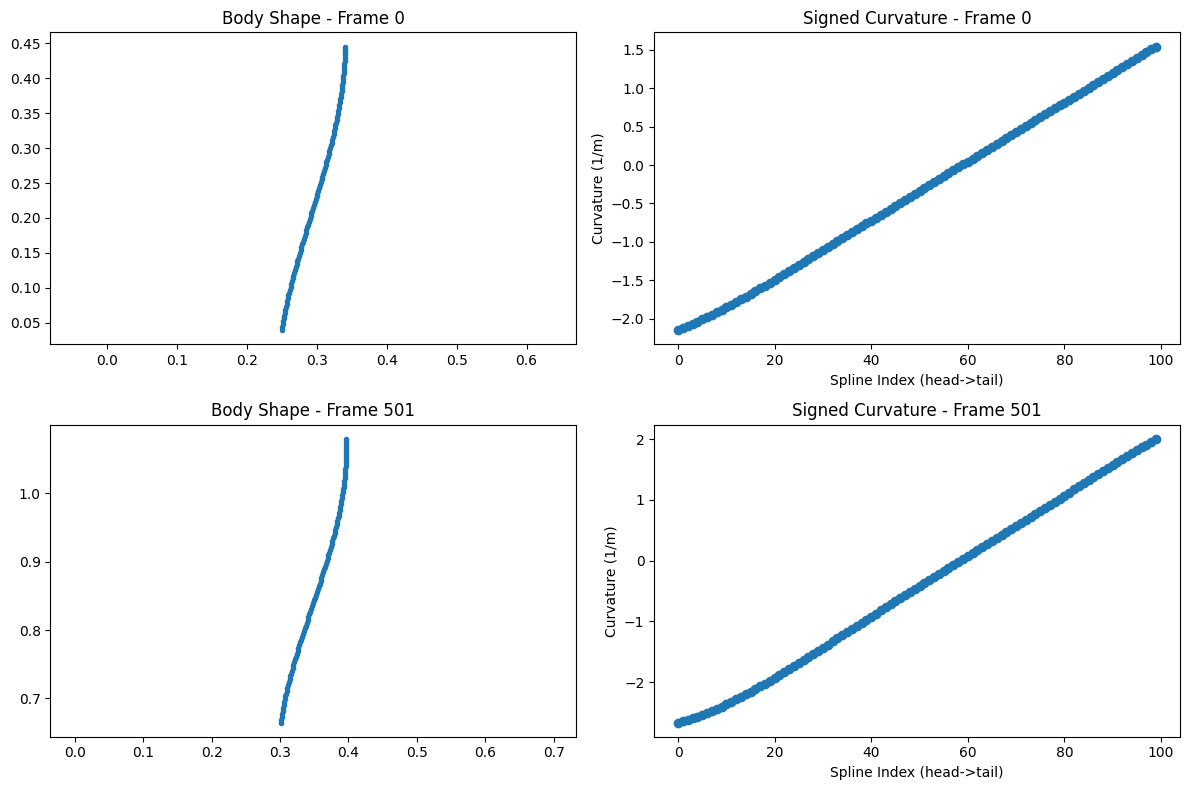

In [18]:
##############################################################################
# 7) PLOT: BODY SHAPE & CURVATURE FOR FRAME 0 AND LAST FRAME
##############################################################################
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Frame 0
axes[0, 0].plot(x_splines[0], y_splines[0], '-o', markersize=3)
axes[0, 0].set_title("Body Shape - Frame 0")
axes[0, 0].axis('equal')

axes[0, 1].plot(curvatures_param[0], '-o')
axes[0, 1].set_title("Signed Curvature - Frame 0")
axes[0, 1].set_xlabel("Spline Index (head->tail)")
axes[0, 1].set_ylabel("Curvature (1/m)")

# Last Frame
axes[1, 0].plot(x_splines[last_frame], y_splines[last_frame], '-o', markersize=3)
axes[1, 0].set_title(f"Body Shape - Frame {last_frame}")
axes[1, 0].axis('equal')

axes[1, 1].plot(curvatures_param[last_frame], '-o')
axes[1, 1].set_title(f"Signed Curvature - Frame {last_frame}")
axes[1, 1].set_xlabel("Spline Index (head->tail)")
axes[1, 1].set_ylabel("Curvature (1/m)")

plt.tight_layout()

fig_save_path = os.path.join(save_folder, "figure_bodyshape_first_last.png")
plt.savefig(fig_save_path, dpi=300)
plt.show()

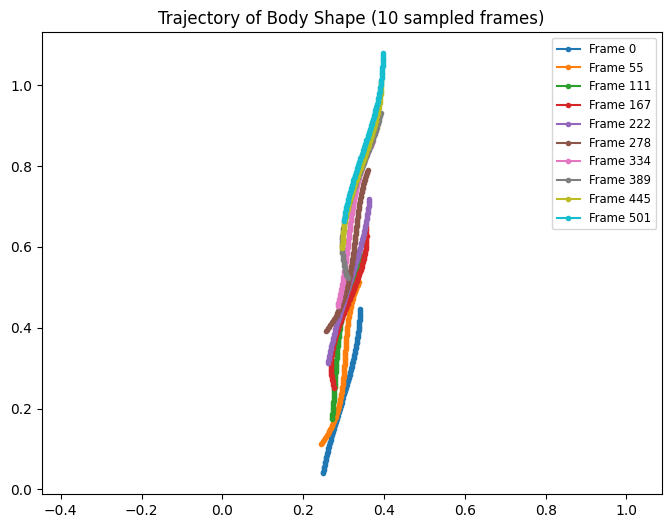

In [19]:
##############################################################################
# 8) PLOT: TRAJECTORY OF THE SPLINE BODY SHAPE (Pick ~10 frames)
##############################################################################
n_samples = 10
sample_frames = np.linspace(0, last_frame, n_samples, dtype=int)

plt.figure(figsize=(8, 6))
for f_idx in sample_frames:
    plt.plot(x_splines[f_idx], y_splines[f_idx], '-o', markersize=3, label=f"Frame {f_idx}")

plt.title("Trajectory of Body Shape (10 sampled frames)")
plt.axis('equal')
plt.legend(loc='best', fontsize='small')

plot_path_trajectory = os.path.join(save_folder, "figure_trajectory.png")
plt.savefig(plot_path_trajectory, dpi=300)
plt.show()

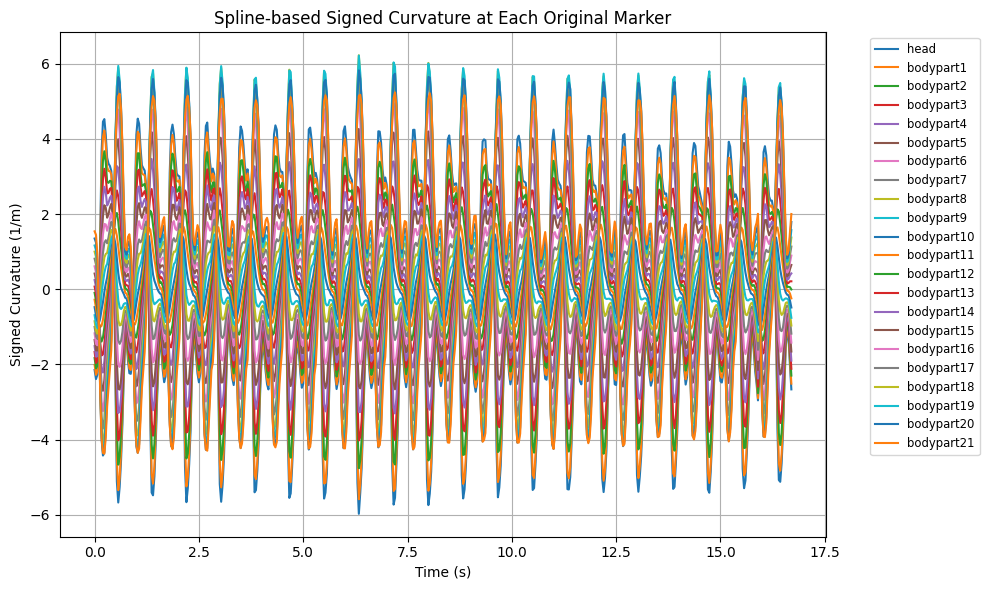

In [20]:
##############################################################################
# 9) PLOT #1: Curvature vs. Time for Each Marker (Marker-based)
##############################################################################
plt.figure(figsize=(10, 6))
for i, marker_name in enumerate(markers_all):
    plt.plot(time_s, curvatures_marker[:, i], label=marker_name)

plt.xlabel('Time (s)')
plt.ylabel('Signed Curvature (1/m)')
plt.title('Spline-based Signed Curvature at Each Original Marker')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()

plot_path_marker_time = os.path.join(save_folder, "figure_curvature_vs_time.png")
plt.savefig(plot_path_marker_time, dpi=300)
plt.show()


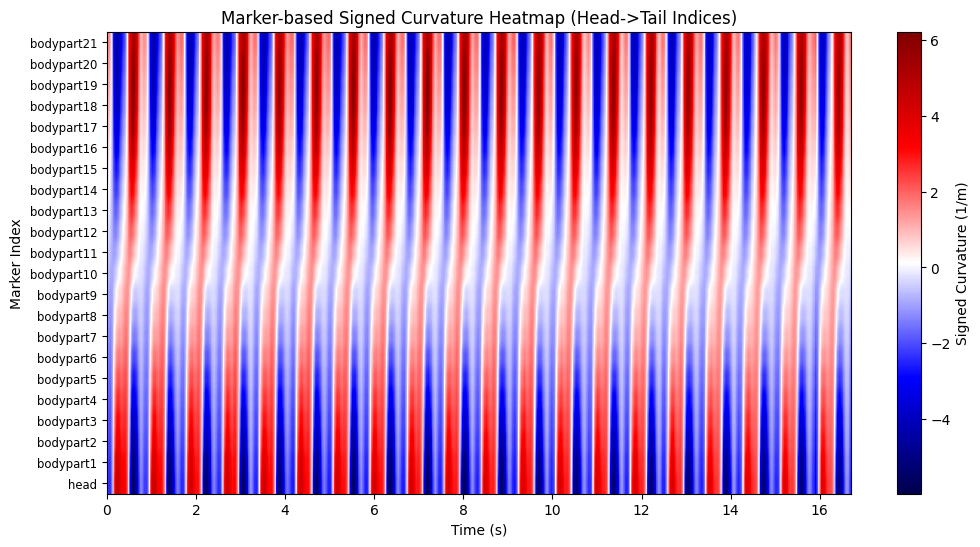

In [21]:
##############################################################################
# 10) PLOT #2: Marker-based Curvature Heatmap
##############################################################################
plt.figure(figsize=(12, 6))
im = plt.imshow(
    curvatures_marker.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, M_markers],
    cmap='seismic'
)
plt.colorbar(im, label='Signed Curvature (1/m)')
plt.title('Marker-based Signed Curvature Heatmap (Head->Tail Indices)')
plt.xlabel('Time (s)')
plt.ylabel('Marker Index')

y_positions = np.arange(M_markers) + 0.5
plt.yticks(y_positions, markers_all, fontsize='small')

plot_path_marker_heat = os.path.join(save_folder, "figure_marker_heatmap.png")
plt.savefig(plot_path_marker_heat, dpi=300)
plt.show()

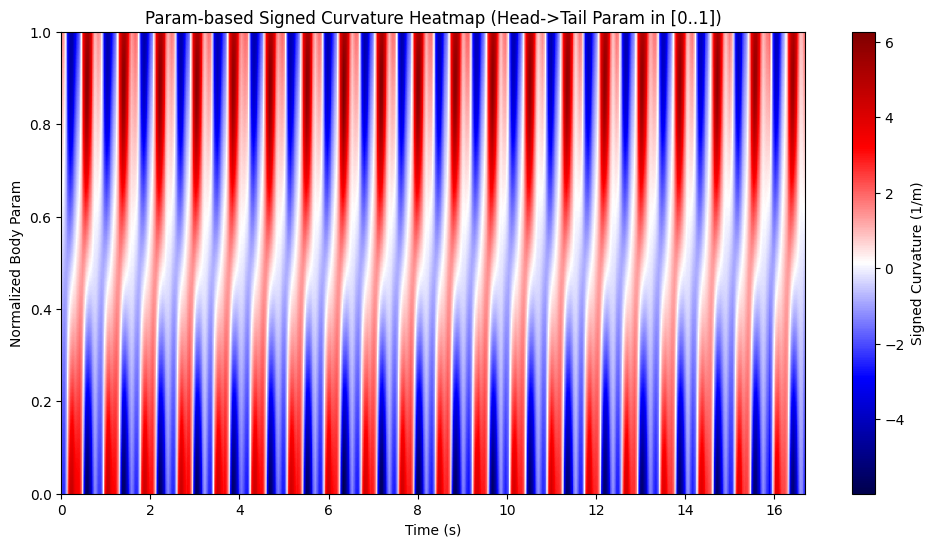

In [22]:
##############################################################################
# 11) PLOT #3: Param-based Curvature Heatmap (Non-Discretized)
##############################################################################
plt.figure(figsize=(12, 6))
im2 = plt.imshow(
    curvatures_param.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'
)
plt.colorbar(im2, label='Signed Curvature (1/m)')
plt.title('Param-based Signed Curvature Heatmap (Head->Tail Param in [0..1])')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param')

plot_path_param_heat = os.path.join(save_folder, "figure_param_heatmap.png")
plt.savefig(plot_path_param_heat, dpi=300)
plt.show()


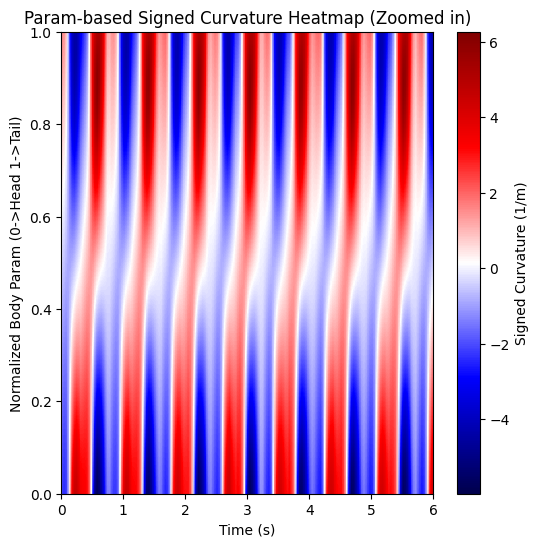


Done! Plots, CSV files, a copy of the original CSV, and cropped data are in: 20250103_105958_plots
Remember: curvature is in 1/m (signed) because x,y are in meters.


In [23]:
##############################################################################
# 12) ZOOMED-IN PLOT
##############################################################################
plt.figure(figsize=(6, 6))
im3 = plt.imshow(
    curvatures_param.T,
    aspect='auto',
    origin='lower',
    extent=[time_s[0], time_s[-1], 0, 1],
    cmap='seismic'
)
plt.colorbar(im3, label='Signed Curvature (1/m)')
plt.title('Param-based Signed Curvature Heatmap (Zoomed in)')
plt.xlabel('Time (s)')
plt.ylabel('Normalized Body Param (0->Head 1->Tail)')
plt.xlim(0,6)

plot_path_zoomed = os.path.join(save_folder, "figure_zoomed.png")
plt.savefig(plot_path_zoomed, dpi=300)
plt.show()
